**Q1**

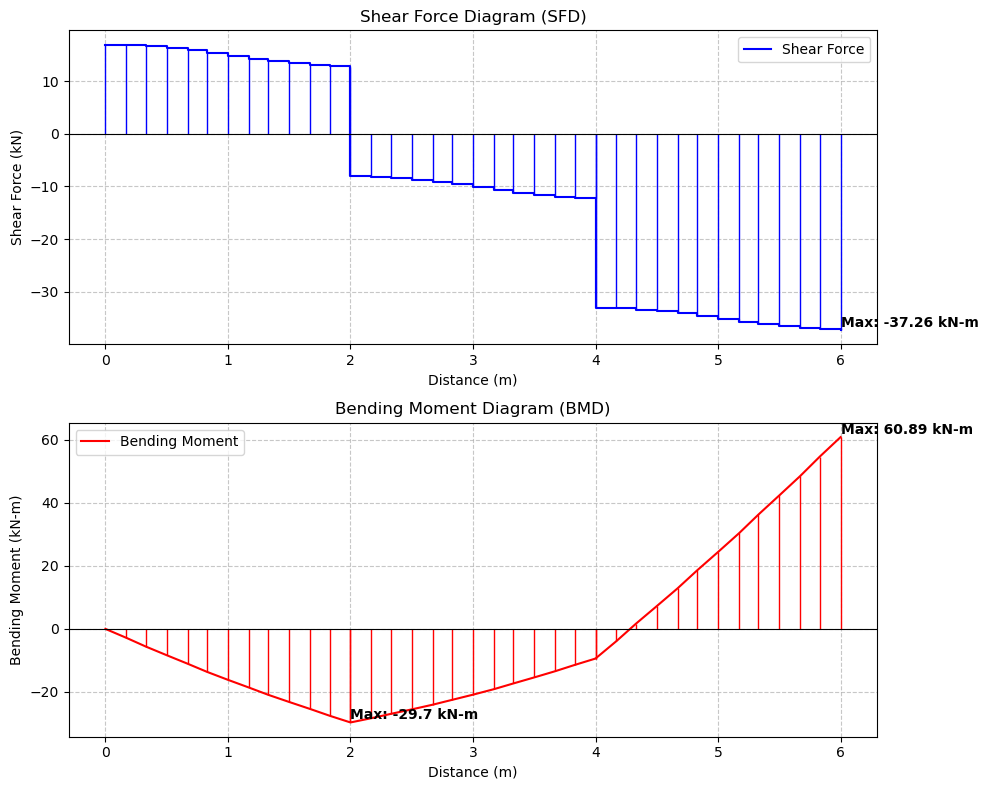

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the provided CSV file
file_path = r"C:\Users\Harsh\Downloads\SFS_Screening_SFDBMD.xlsx - Sheet1.csv"
data = pd.read_csv(file_path)

# Extracting data for plotting
x = data['Distance (m)']
shear_force = data['SF (kN)']
bending_moment = data['BM (kN-m)']

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# --- Shear Force Diagram (SFD) ---
axes[0].plot(x, shear_force, drawstyle='steps-post', color='b', linewidth=1.5, label='Shear Force')

# Vertical lines showing step changes between points
for i in range(len(x) - 1):
    axes[0].vlines(x[i+1], shear_force[i], shear_force[i+1], colors='blue', linewidth=1.5, linestyles='solid')

# Add dashed vertical lines from each point to the x-axis
for xi, sf in zip(x, shear_force):
    axes[0].vlines(xi, 0, sf, colors='blue', linestyles='solid', linewidth=1)

# Printing max values in the plots
dist_value = 6
sfd_value = data.loc[data['Distance (m)'] == dist_value, 'SF (kN)'].values[0]
axes[0].text(dist_value, sfd_value, f"Max: {sfd_value:.2f} kN-m", 
             fontsize=10, color='black', ha='left', va='bottom', fontweight='bold')

dist_value = 2
bm_value = data.loc[data['Distance (m)'] == dist_value, 'BM (kN-m)'].values[0]

dist_value1=6
bm_value1 = data.loc[data['Distance (m)'] == dist_value1, 'BM (kN-m)'].values[0]
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Shear Force (kN)")
axes[0].set_title("Shear Force Diagram (SFD)")
axes[0].legend()
axes[0].grid(True, linestyle='dashed', alpha=0.7)

# --- Bending Moment Diagram (BMD) ---
axes[1].plot(x, bending_moment, color='r', linewidth=1.5, label='Bending Moment')

# Add dashed vertical lines from each point to the x-axis
for xi, bm in zip(x, bending_moment):
    axes[1].vlines(xi, 0, bm, colors='red', linestyles='solid', linewidth=1)
axes[1].text(dist_value, bm_value, f"Max: {bm_value} kN-m", 
             fontsize=10, color='black', ha='left', va='bottom', fontweight='bold')
axes[1].text(dist_value1, bm_value1, f"Max: {bm_value1} kN-m", 
             fontsize=10, color='black', ha='left', va='bottom', fontweight='bold')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Bending Moment (kN-m)")
axes[1].set_title("Bending Moment Diagram (BMD)")
axes[1].legend()
axes[1].grid(True, linestyle='dashed', alpha=0.7)

plt.tight_layout()
plt.show()


**Q2**

In [25]:
from OCC.Core.gp import gp_Vec, gp_Trsf, gp_Pnt, gp_Dir, gp_Ax1
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Fuse
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform, BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeWire, BRepBuilderAPI_MakeFace
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakePrism
from OCC.Display.SimpleGui import init_display
import math

def create_i_section(length, width, depth, flange_thickness, web_thickness):
    web_height = depth - 2 * flange_thickness

    bottom_flange = BRepPrimAPI_MakeBox(length, width, flange_thickness).Shape()
    top_flange = BRepPrimAPI_MakeBox(length, width, flange_thickness).Shape()
    trsf = gp_Trsf()
    trsf.SetTranslation(gp_Vec(0, 0, depth - flange_thickness))
    top_flange_transform = BRepBuilderAPI_Transform(top_flange, trsf, True).Shape()

    web = BRepPrimAPI_MakeBox(length, web_thickness, web_height).Shape()
    trsf = gp_Trsf()
    trsf.SetTranslation(gp_Vec(0, (width - web_thickness) / 2, flange_thickness))
    web_transform = BRepBuilderAPI_Transform(web, trsf, True).Shape()

    i_section_solid = BRepAlgoAPI_Fuse(bottom_flange, top_flange_transform).Shape()
    i_section_solid = BRepAlgoAPI_Fuse(i_section_solid, web_transform).Shape()

    return i_section_solid

def create_end_batten(length, width, depth, column_distance):
    batten = BRepPrimAPI_MakeBox(length, column_distance + width, depth).Shape()
    return batten

def create_straight_lace(width, thickness, length):
    # Create a horizontal lace plate
    lace = BRepPrimAPI_MakeBox(length, width, thickness).Shape()
    return lace

def create_parallelogram_face(p1, p2, p3, thickness):
    # Calculate the fourth point (Top-right)
    vec1 = gp_Vec(p1, p2)  # Base vector
    p4 = gp_Pnt(p3.XYZ() + vec1.XYZ())  # Top-right = Top-left + base vector

    # Create edges
    edge1 = BRepBuilderAPI_MakeEdge(p1, p2).Edge()
    edge2 = BRepBuilderAPI_MakeEdge(p2, p4).Edge()
    edge3 = BRepBuilderAPI_MakeEdge(p4, p3).Edge()
    edge4 = BRepBuilderAPI_MakeEdge(p3, p1).Edge()

    # Make wire
    wire = BRepBuilderAPI_MakeWire(edge1, edge2, edge3, edge4).Wire()

    # Make face
    face = BRepBuilderAPI_MakeFace(wire).Face()
    
    # Extrude the face into a solid
    vec = gp_Vec(0, 0, thickness)
    prism = BRepPrimAPI_MakePrism(face, vec).Shape()
    
    return prism

if __name__ == "__main__":
    column_length = 6100.0  # Total column length
    i_section_width = 100.0  # Width of I-section
    i_section_height = 200.0  # Height of I-section
    flange_thickness = 10.0
    web_thickness = 5.0
    column_distance = 450.0  # Distance between I-sections (center to center)
    
    # End batten parameters
    batten_depth = 300.0
    batten_thickness = 10.0
    
    # Lace parameters
    lace_width = 100.0
    lace_thickness = 8.0
    
    # Create the two I-sections
    i_section1 = create_i_section(column_length, i_section_width, i_section_height, flange_thickness, web_thickness)
    
    trsf = gp_Trsf()
    trsf.SetTranslation(gp_Vec(0, column_distance, 0))
    i_section2 = BRepBuilderAPI_Transform(i_section1, trsf, True).Shape()
    
    # Create end battens (top and bottom)
    # Create bottom battens at z=0
    bottom_batten_left = create_end_batten(batten_depth, i_section_width, -batten_thickness, column_distance)
    temp_bottom_right = create_end_batten(-batten_depth, i_section_width, -batten_thickness, column_distance)

    # Position the right bottom batten
    trsf_bottom_right = gp_Trsf()
    trsf_bottom_right.SetTranslation(gp_Vec(column_length - batten_thickness, 0, 0))
    bottom_batten_right = BRepBuilderAPI_Transform(temp_bottom_right, trsf_bottom_right, True).Shape()

    # Create top battens at z=i_section_height
    temp_top_left = create_end_batten(batten_depth, i_section_width, batten_thickness, column_distance)
    temp_top_right = create_end_batten(-batten_depth, i_section_width, batten_thickness, column_distance)

    # Position the left top batten
    trsf_top_left = gp_Trsf()
    trsf_top_left.SetTranslation(gp_Vec(0, 0, i_section_height))
    top_batten_left = BRepBuilderAPI_Transform(temp_top_left, trsf_top_left, True).Shape()

    # Position the right top batten - need both horizontal and vertical translation
    trsf_top_right = gp_Trsf()
    trsf_top_right.SetTranslation(gp_Vec(column_length - batten_thickness, 0, i_section_height))
    top_batten_right = BRepBuilderAPI_Transform(temp_top_right, trsf_top_right, True).Shape()

    # Combine all elements
    combined_structure = BRepAlgoAPI_Fuse(i_section1, i_section2).Shape()
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, bottom_batten_left).Shape()
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, bottom_batten_right).Shape()
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, top_batten_left).Shape()
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, top_batten_right).Shape()
    
    # Calculate diagonal lace length and spacing
    lace_spacing = i_section_height  # Distance between laces
    
    # Create diagonal laces
    start_laces = batten_depth + column_distance
    step_size = column_distance + lace_width
    end_lace = column_length - column_distance - lace_width - batten_depth
    num_laces = int((end_lace - start_laces) / step_size) + 1
    
    for i in range(num_laces):
        
        # Create parallelogram (diagonal plate) using the new function
        p1 = gp_Pnt(batten_depth+450+i*550, 350+2*lace_width, i_section_height)
        p2 = gp_Pnt(batten_depth+450-lace_width + i*550,350.0+2*lace_width, i_section_height)
        p3 = gp_Pnt(batten_depth+lace_width+i*550, 0,i_section_height)
        
        # Create solid from the face and add to structure
        diagonal_plate = create_parallelogram_face(p1, p2, p3, lace_thickness)
        combined_structure = BRepAlgoAPI_Fuse(combined_structure, diagonal_plate).Shape()
        
        # Create backward diagonal lace (\)

        if(i==0):
            b_p1 = gp_Pnt(batten_depth+550+i*550, column_distance+lace_width, -lace_thickness)  # Bottom left
            b_p2 = gp_Pnt(batten_depth +lace_width+ i*550, 0, -lace_thickness)  # Bottom right
            b_p3 = gp_Pnt(batten_depth+550-lace_width+i*550, column_distance+lace_width, -lace_thickness)  # Top left 
        else:
            b_p1 = gp_Pnt(batten_depth+550+i*550, column_distance+lace_width, -lace_thickness)  # Bottom left
            b_p2 = gp_Pnt(batten_depth +2*lace_width+ i*550, 0, -lace_thickness)  # Bottom right
            b_p3 = gp_Pnt(batten_depth+550-lace_width+i*550, column_distance+lace_width, -lace_thickness)  # Top left
    
    # Create backward diagonal plate
        backward_diagonal_plate = create_parallelogram_face(b_p1, b_p2, b_p3, lace_thickness)
        combined_structure = BRepAlgoAPI_Fuse(combined_structure, backward_diagonal_plate).Shape()

        # Create horizontal connecting laces
        lace_straight_position_x = (batten_depth + 550) + (i * 550)
        
        # Create horizontal lace (vertical orientation)
        lace1_straight = create_straight_lace(lace_width, lace_thickness, column_distance + lace_width)
        
        # Rotate to vertical orientation (90 degrees around Z)
        trsf1_straight = gp_Trsf()
        rotation_axis1 = gp_Ax1(gp_Pnt(0, 0, 0), gp_Dir(0, 0, 1))
        trsf1_straight.SetRotation(rotation_axis1, math.radians(90))
        lace1_rotated_straight = BRepBuilderAPI_Transform(lace1_straight, trsf1_straight, True).Shape()
        
        # Position the rotated lace
        trsf_pos1_straight = gp_Trsf()
        trsf_pos1_straight.SetTranslation(gp_Vec(lace_straight_position_x, 0, i_section_height/2 + (i_section_width)))
        positioned_lace1_straight = BRepBuilderAPI_Transform(lace1_rotated_straight, trsf_pos1_straight, True).Shape()

        # Create second horizontal lace
        lace2_straight = create_straight_lace(lace_width, lace_thickness, column_distance+lace_width)
        
        # Rotate to vertical orientation (negative 90 degrees around Z)
        trsf2_straight = gp_Trsf()
        rotation_axis2 = gp_Ax1(gp_Pnt(0, 0, 0), gp_Dir(0, 0, 1))
        trsf2_straight.SetRotation(rotation_axis2, math.radians(-90))
        lace2_rotated_straight = BRepBuilderAPI_Transform(lace2_straight, trsf2_straight, True).Shape()
        
        # Position the rotated lace
        trsf_pos2_straight = gp_Trsf()
        trsf_pos2_straight.SetTranslation(gp_Vec(lace_straight_position_x, column_distance+lace_width, i_section_height/2 - (i_section_width)-lace_thickness))
        positioned_lace2_straight = BRepBuilderAPI_Transform(lace2_rotated_straight, trsf_pos2_straight, True).Shape()
        
        # Add horizontal laces to structure
        combined_structure = BRepAlgoAPI_Fuse(combined_structure, positioned_lace1_straight).Shape()
        combined_structure = BRepAlgoAPI_Fuse(combined_structure, positioned_lace2_straight).Shape()
    
    # Add final diagonal lace at the end

    p1 = gp_Pnt(batten_depth+lace_width+450+9*550, 350+2*lace_width, i_section_height)
    p2 = gp_Pnt(batten_depth+column_distance+ 9*550,350.0+2*lace_width, i_section_height)
    p3 = gp_Pnt(batten_depth+lace_width+9*550, 0,i_section_height)
        
    diagonal_plate = create_parallelogram_face(p1, p2, p3, lace_thickness)
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, diagonal_plate).Shape()

    
    # Add final backward diagonal lace (\)
    b_p1 = gp_Pnt(batten_depth+550+9*550, column_distance+lace_width, -lace_thickness)  # Bottom left
    b_p2 = gp_Pnt(batten_depth +200+ 9*550, 0, -lace_thickness)  # Bottom right
    b_p3 = gp_Pnt(batten_depth+550-lace_width+9*550, column_distance+lace_width, -lace_thickness)  # Top left

    diagonal_plate1 = create_parallelogram_face(b_p1, b_p2, b_p3, lace_thickness)
    combined_structure = BRepAlgoAPI_Fuse(combined_structure, diagonal_plate1).Shape()
    
    # Display the structure
    display, start_display, add_menu, add_function_to_menu = init_display()
    display.DisplayShape(combined_structure, update=True)
    display.FitAll()
    start_display()

pyqt5 backend - Qt version 5.15.2
